# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 100

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_SGD_nasterov'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../../data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
scheduler = ExponentialLR(optimizer, gamma=0.95)

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.1

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100] :


1 Train: 100%|███████| 391/391 [00:36<00:00, 10.63it/s]

Train Loss: 2.5058 | Train Acc: 10.01%


Test  Loss: 2.3128 | Test Acc: 10.00%
updated best eval loss : 2.3127765957313247
--------------------------------------------------
[Epoch 2/100] :


2 Train: 100%|███████| 391/391 [00:29<00:00, 13.34it/s]


Train Loss: 2.3045 | Train Acc: 9.89%
Test  Loss: 2.3084 | Test Acc: 9.98%
updated best eval loss : 2.308395062820821
--------------------------------------------------
[Epoch 3/100] :


3 Train: 100%|███████| 391/391 [00:29<00:00, 13.14it/s]


Train Loss: 2.3043 | Train Acc: 9.88%
Test  Loss: 2.3066 | Test Acc: 8.06%
updated best eval loss : 2.306585435625873
--------------------------------------------------
[Epoch 4/100] :


4 Train: 100%|███████| 391/391 [00:29<00:00, 13.41it/s]


Train Loss: 2.3043 | Train Acc: 9.95%
Test  Loss: 2.3308 | Test Acc: 10.60%
--------------------------------------------------
[Epoch 5/100] :


5 Train: 100%|███████| 391/391 [00:28<00:00, 13.50it/s]


Train Loss: 2.3042 | Train Acc: 9.95%
Test  Loss: 2.3160 | Test Acc: 9.76%
--------------------------------------------------
[Epoch 6/100] :


6 Train: 100%|███████| 391/391 [00:28<00:00, 13.78it/s]


Train Loss: 2.3040 | Train Acc: 10.22%
Test  Loss: 2.3099 | Test Acc: 9.08%
--------------------------------------------------
[Epoch 7/100] :


7 Train: 100%|███████| 391/391 [00:30<00:00, 12.99it/s]


Train Loss: 2.3042 | Train Acc: 10.13%
Test  Loss: 2.3110 | Test Acc: 9.94%
--------------------------------------------------
[Epoch 8/100] :


8 Train: 100%|███████| 391/391 [00:31<00:00, 12.44it/s]


Train Loss: 2.3042 | Train Acc: 9.84%
Test  Loss: 2.3044 | Test Acc: 10.00%
updated best eval loss : 2.3044359985786147
--------------------------------------------------
[Epoch 9/100] :


9 Train: 100%|███████| 391/391 [00:34<00:00, 11.17it/s]


Train Loss: 2.3041 | Train Acc: 9.98%
Test  Loss: 2.3051 | Test Acc: 10.00%
--------------------------------------------------
[Epoch 10/100] :


10 Train: 100%|██████| 391/391 [00:45<00:00,  8.66it/s]


Train Loss: 2.3041 | Train Acc: 9.93%
Test  Loss: 2.3050 | Test Acc: 10.00%
--------------------------------------------------
[Epoch 11/100] :


11 Train: 100%|██████| 391/391 [00:47<00:00,  8.20it/s]


Train Loss: 2.3044 | Train Acc: 9.89%
Test  Loss: 2.3042 | Test Acc: 9.99%
updated best eval loss : 2.3042387026774733
--------------------------------------------------
[Epoch 12/100] :


12 Train: 100%|██████| 391/391 [00:37<00:00, 10.53it/s]


Train Loss: 2.3044 | Train Acc: 9.75%
Test  Loss: 2.3045 | Test Acc: 10.00%
--------------------------------------------------
[Epoch 13/100] :


13 Train: 100%|██████| 391/391 [00:34<00:00, 11.48it/s]


Train Loss: 2.3045 | Train Acc: 9.93%
Test  Loss: 2.3040 | Test Acc: 9.81%
updated best eval loss : 2.303977344609514
--------------------------------------------------
[Epoch 14/100] :


14 Train: 100%|██████| 391/391 [00:34<00:00, 11.33it/s]


Train Loss: 2.3046 | Train Acc: 9.95%
Test  Loss: 2.3055 | Test Acc: 10.00%
--------------------------------------------------
[Epoch 15/100] :


15 Train: 100%|██████| 391/391 [00:34<00:00, 11.43it/s]


Train Loss: 2.3044 | Train Acc: 9.75%
Test  Loss: 2.3080 | Test Acc: 10.00%
--------------------------------------------------
[Epoch 16/100] :


16 Train: 100%|██████| 391/391 [00:35<00:00, 11.06it/s]


Train Loss: 2.3043 | Train Acc: 10.03%
Test  Loss: 2.3120 | Test Acc: 9.69%
--------------------------------------------------
[Epoch 17/100] :


17 Train: 100%|██████| 391/391 [00:32<00:00, 12.15it/s]


Train Loss: 2.3037 | Train Acc: 9.73%
Test  Loss: 2.3037 | Test Acc: 10.00%
updated best eval loss : 2.3036653391922575
--------------------------------------------------
[Epoch 18/100] :


18 Train: 100%|██████| 391/391 [00:32<00:00, 11.87it/s]


Train Loss: 2.1442 | Train Acc: 17.82%
Test  Loss: 1.8896 | Test Acc: 27.86%
updated best eval loss : 1.8895640871192836
--------------------------------------------------
[Epoch 19/100] :


19 Train: 100%|██████| 391/391 [00:32<00:00, 11.88it/s]


Train Loss: 1.7026 | Train Acc: 36.88%
Test  Loss: 1.3869 | Test Acc: 49.34%
updated best eval loss : 1.3869225722324998
--------------------------------------------------
[Epoch 20/100] :


20 Train: 100%|██████| 391/391 [00:32<00:00, 11.98it/s]


Train Loss: 1.2830 | Train Acc: 54.08%
Test  Loss: 1.4557 | Test Acc: 53.25%
--------------------------------------------------
[Epoch 21/100] :


21 Train: 100%|██████| 391/391 [00:33<00:00, 11.74it/s]


Train Loss: 1.0479 | Train Acc: 63.11%
Test  Loss: 1.1151 | Test Acc: 61.99%
updated best eval loss : 1.1150988981693606
--------------------------------------------------
[Epoch 22/100] :


22 Train: 100%|██████| 391/391 [00:36<00:00, 10.72it/s]


Train Loss: 0.9272 | Train Acc: 67.54%
Test  Loss: 1.2642 | Test Acc: 58.94%
--------------------------------------------------
[Epoch 23/100] :


23 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.8472 | Train Acc: 70.41%
Test  Loss: 0.8290 | Test Acc: 72.21%
updated best eval loss : 0.8289915926848785
--------------------------------------------------
[Epoch 24/100] :


24 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.7889 | Train Acc: 72.61%
Test  Loss: 0.7490 | Test Acc: 73.56%
updated best eval loss : 0.7489815799495841
--------------------------------------------------
[Epoch 25/100] :


25 Train: 100%|██████| 391/391 [00:47<00:00,  8.21it/s]


Train Loss: 0.7566 | Train Acc: 73.87%
Test  Loss: 1.0321 | Test Acc: 66.70%
--------------------------------------------------
[Epoch 26/100] :


26 Train: 100%|██████| 391/391 [00:46<00:00,  8.47it/s]


Train Loss: 0.7172 | Train Acc: 75.02%
Test  Loss: 0.7898 | Test Acc: 72.41%
--------------------------------------------------
[Epoch 27/100] :


27 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.6939 | Train Acc: 75.88%
Test  Loss: 0.7328 | Test Acc: 75.66%
updated best eval loss : 0.7327636231349993
--------------------------------------------------
[Epoch 28/100] :


28 Train: 100%|██████| 391/391 [00:46<00:00,  8.34it/s]


Train Loss: 0.6666 | Train Acc: 76.88%
Test  Loss: 0.8026 | Test Acc: 71.88%
--------------------------------------------------
[Epoch 29/100] :


29 Train: 100%|██████| 391/391 [00:47<00:00,  8.15it/s]


Train Loss: 0.6511 | Train Acc: 77.60%
Test  Loss: 0.8666 | Test Acc: 71.74%
--------------------------------------------------
[Epoch 30/100] :


30 Train: 100%|██████| 391/391 [00:45<00:00,  8.58it/s]


Train Loss: 0.6319 | Train Acc: 77.93%
Test  Loss: 0.7535 | Test Acc: 73.36%
--------------------------------------------------
[Epoch 31/100] :


31 Train: 100%|██████| 391/391 [00:50<00:00,  7.75it/s]


Train Loss: 0.6248 | Train Acc: 78.49%
Test  Loss: 0.8961 | Test Acc: 70.63%
--------------------------------------------------
[Epoch 32/100] :


32 Train: 100%|██████| 391/391 [00:47<00:00,  8.23it/s]


Train Loss: 0.6087 | Train Acc: 78.99%
Test  Loss: 0.6743 | Test Acc: 76.94%
updated best eval loss : 0.6743057434317432
--------------------------------------------------
[Epoch 33/100] :


33 Train: 100%|██████| 391/391 [00:49<00:00,  7.86it/s]


Train Loss: 0.5938 | Train Acc: 79.41%
Test  Loss: 0.7139 | Test Acc: 76.05%
--------------------------------------------------
[Epoch 34/100] :


34 Train: 100%|██████| 391/391 [00:46<00:00,  8.43it/s]


Train Loss: 0.5810 | Train Acc: 79.92%
Test  Loss: 0.6722 | Test Acc: 77.06%
updated best eval loss : 0.6721976588043985
--------------------------------------------------
[Epoch 35/100] :


35 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.5690 | Train Acc: 80.30%
Test  Loss: 0.8203 | Test Acc: 73.69%
--------------------------------------------------
[Epoch 36/100] :


36 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.5646 | Train Acc: 80.39%
Test  Loss: 0.5709 | Test Acc: 80.59%
updated best eval loss : 0.5709461984755118
--------------------------------------------------
[Epoch 37/100] :


37 Train: 100%|██████| 391/391 [00:46<00:00,  8.48it/s]


Train Loss: 0.5521 | Train Acc: 80.90%
Test  Loss: 0.8884 | Test Acc: 70.58%
--------------------------------------------------
[Epoch 38/100] :


38 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.5487 | Train Acc: 80.81%
Test  Loss: 0.6785 | Test Acc: 77.41%
--------------------------------------------------
[Epoch 39/100] :


39 Train: 100%|██████| 391/391 [00:46<00:00,  8.47it/s]


Train Loss: 0.5374 | Train Acc: 81.27%
Test  Loss: 0.7396 | Test Acc: 75.61%
--------------------------------------------------
[Epoch 40/100] :


40 Train: 100%|██████| 391/391 [00:50<00:00,  7.82it/s]


Train Loss: 0.5292 | Train Acc: 81.70%
Test  Loss: 0.6321 | Test Acc: 78.87%
--------------------------------------------------
[Epoch 41/100] :


41 Train: 100%|██████| 391/391 [00:45<00:00,  8.66it/s]


Train Loss: 0.5268 | Train Acc: 81.69%
Test  Loss: 0.7043 | Test Acc: 76.98%
--------------------------------------------------
[Epoch 42/100] :


42 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.5199 | Train Acc: 82.06%
Test  Loss: 0.8584 | Test Acc: 72.16%
--------------------------------------------------
[Epoch 43/100] :


43 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.5149 | Train Acc: 82.22%
Test  Loss: 0.6518 | Test Acc: 78.00%
--------------------------------------------------
[Epoch 44/100] :


44 Train: 100%|██████| 391/391 [00:46<00:00,  8.44it/s]


Train Loss: 0.5058 | Train Acc: 82.59%
Test  Loss: 0.6481 | Test Acc: 78.12%
--------------------------------------------------
[Epoch 45/100] :


45 Train: 100%|██████| 391/391 [00:46<00:00,  8.49it/s]


Train Loss: 0.5019 | Train Acc: 82.60%
Test  Loss: 0.7239 | Test Acc: 76.36%
--------------------------------------------------
[Epoch 46/100] :


46 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.4975 | Train Acc: 82.70%
Test  Loss: 0.6484 | Test Acc: 78.75%
--------------------------------------------------
[Epoch 47/100] :


47 Train: 100%|██████| 391/391 [00:45<00:00,  8.56it/s]


Train Loss: 0.4963 | Train Acc: 82.71%
Test  Loss: 0.6211 | Test Acc: 79.15%
--------------------------------------------------
[Epoch 48/100] :


48 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.4926 | Train Acc: 82.95%
Test  Loss: 0.5621 | Test Acc: 81.81%
updated best eval loss : 0.5620867760875558
--------------------------------------------------
[Epoch 49/100] :


49 Train: 100%|██████| 391/391 [00:45<00:00,  8.61it/s]


Train Loss: 0.4886 | Train Acc: 82.87%
Test  Loss: 0.6222 | Test Acc: 78.45%
--------------------------------------------------
[Epoch 50/100] :


50 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.4823 | Train Acc: 83.29%
Test  Loss: 0.5769 | Test Acc: 80.65%
--------------------------------------------------
[Epoch 51/100] :


51 Train: 100%|██████| 391/391 [00:46<00:00,  8.34it/s]


Train Loss: 0.4823 | Train Acc: 83.28%
Test  Loss: 0.4813 | Test Acc: 83.50%
updated best eval loss : 0.4813146806215938
--------------------------------------------------
[Epoch 52/100] :


52 Train: 100%|██████| 391/391 [00:47<00:00,  8.24it/s]


Train Loss: 0.4738 | Train Acc: 83.45%
Test  Loss: 0.7482 | Test Acc: 75.10%
--------------------------------------------------
[Epoch 53/100] :


53 Train: 100%|██████| 391/391 [00:45<00:00,  8.62it/s]


Train Loss: 0.4720 | Train Acc: 83.54%
Test  Loss: 0.5866 | Test Acc: 80.26%
--------------------------------------------------
[Epoch 54/100] :


54 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.4704 | Train Acc: 83.69%
Test  Loss: 0.5961 | Test Acc: 80.73%
--------------------------------------------------
[Epoch 55/100] :


55 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.4619 | Train Acc: 83.91%
Test  Loss: 0.5069 | Test Acc: 83.11%
--------------------------------------------------
[Epoch 56/100] :


56 Train: 100%|██████| 391/391 [00:47<00:00,  8.28it/s]


Train Loss: 0.4611 | Train Acc: 84.10%
Test  Loss: 0.5982 | Test Acc: 80.16%
--------------------------------------------------
[Epoch 57/100] :


57 Train: 100%|██████| 391/391 [00:45<00:00,  8.60it/s]


Train Loss: 0.4614 | Train Acc: 83.97%
Test  Loss: 0.5304 | Test Acc: 81.76%
--------------------------------------------------
[Epoch 58/100] :


58 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.4578 | Train Acc: 83.94%
Test  Loss: 0.5941 | Test Acc: 80.01%
--------------------------------------------------
[Epoch 59/100] :


59 Train: 100%|██████| 391/391 [00:45<00:00,  8.52it/s]


Train Loss: 0.4535 | Train Acc: 84.17%
Test  Loss: 0.7119 | Test Acc: 77.84%
--------------------------------------------------
[Epoch 60/100] :


60 Train: 100%|██████| 391/391 [00:46<00:00,  8.41it/s]


Train Loss: 0.4560 | Train Acc: 84.25%
Test  Loss: 0.6351 | Test Acc: 79.03%
--------------------------------------------------
[Epoch 61/100] :


61 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.4521 | Train Acc: 84.26%
Test  Loss: 0.7373 | Test Acc: 76.38%
--------------------------------------------------
[Epoch 62/100] :


62 Train: 100%|██████| 391/391 [00:47<00:00,  8.27it/s]


Train Loss: 0.4495 | Train Acc: 84.37%
Test  Loss: 0.5710 | Test Acc: 80.68%
--------------------------------------------------
[Epoch 63/100] :


63 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.4422 | Train Acc: 84.54%
Test  Loss: 0.6351 | Test Acc: 79.26%
--------------------------------------------------
[Epoch 64/100] :


64 Train: 100%|██████| 391/391 [00:45<00:00,  8.68it/s]


Train Loss: 0.4455 | Train Acc: 84.46%
Test  Loss: 0.5777 | Test Acc: 80.16%
--------------------------------------------------
[Epoch 65/100] :


65 Train: 100%|██████| 391/391 [00:46<00:00,  8.38it/s]


Train Loss: 0.4437 | Train Acc: 84.49%
Test  Loss: 0.7174 | Test Acc: 76.33%
--------------------------------------------------
[Epoch 66/100] :


66 Train: 100%|██████| 391/391 [00:46<00:00,  8.35it/s]


Train Loss: 0.4420 | Train Acc: 84.59%
Test  Loss: 0.5172 | Test Acc: 82.72%
--------------------------------------------------
[Epoch 67/100] :


67 Train: 100%|██████| 391/391 [00:45<00:00,  8.62it/s]


Train Loss: 0.4374 | Train Acc: 84.83%
Test  Loss: 0.6984 | Test Acc: 78.57%
--------------------------------------------------
[Epoch 68/100] :


68 Train: 100%|██████| 391/391 [00:46<00:00,  8.47it/s]


Train Loss: 0.4432 | Train Acc: 84.70%
Test  Loss: 0.6627 | Test Acc: 77.90%
--------------------------------------------------
[Epoch 69/100] :


69 Train: 100%|██████| 391/391 [00:46<00:00,  8.45it/s]


Train Loss: 0.4290 | Train Acc: 85.08%
Test  Loss: 0.5757 | Test Acc: 81.65%
--------------------------------------------------
[Epoch 70/100] :


70 Train: 100%|██████| 391/391 [00:45<00:00,  8.54it/s]


Train Loss: 0.4386 | Train Acc: 84.81%
Test  Loss: 0.5941 | Test Acc: 80.15%
--------------------------------------------------
[Epoch 71/100] :


71 Train: 100%|██████| 391/391 [00:48<00:00,  8.13it/s]


Train Loss: 0.4314 | Train Acc: 84.89%
Test  Loss: 0.7602 | Test Acc: 74.63%
--------------------------------------------------
[Epoch 72/100] :


72 Train: 100%|██████| 391/391 [00:47<00:00,  8.18it/s]


Train Loss: 0.4302 | Train Acc: 84.91%
Test  Loss: 0.4764 | Test Acc: 84.95%
updated best eval loss : 0.4764007288443891
--------------------------------------------------
[Epoch 73/100] :


73 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.4258 | Train Acc: 85.22%
Test  Loss: 0.5783 | Test Acc: 80.07%
--------------------------------------------------
[Epoch 74/100] :


74 Train: 100%|██████| 391/391 [00:46<00:00,  8.33it/s]


Train Loss: 0.4314 | Train Acc: 84.98%
Test  Loss: 0.5974 | Test Acc: 80.20%
--------------------------------------------------
[Epoch 75/100] :


75 Train: 100%|██████| 391/391 [00:46<00:00,  8.45it/s]


Train Loss: 0.4233 | Train Acc: 85.28%
Test  Loss: 0.7183 | Test Acc: 76.56%
--------------------------------------------------
[Epoch 76/100] :


76 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.4285 | Train Acc: 85.14%
Test  Loss: 0.4255 | Test Acc: 85.55%
updated best eval loss : 0.42548458070694645
--------------------------------------------------
[Epoch 77/100] :


77 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.4251 | Train Acc: 85.36%
Test  Loss: 0.4770 | Test Acc: 84.06%
--------------------------------------------------
[Epoch 78/100] :


78 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.4178 | Train Acc: 85.31%
Test  Loss: 0.5215 | Test Acc: 82.72%
--------------------------------------------------
[Epoch 79/100] :


79 Train: 100%|██████| 391/391 [00:48<00:00,  8.15it/s]


Train Loss: 0.4180 | Train Acc: 85.43%
Test  Loss: 0.4357 | Test Acc: 85.25%
--------------------------------------------------
[Epoch 80/100] :


80 Train: 100%|██████| 391/391 [00:46<00:00,  8.43it/s]


Train Loss: 0.4157 | Train Acc: 85.51%
Test  Loss: 0.6594 | Test Acc: 78.31%
--------------------------------------------------
[Epoch 81/100] :


81 Train: 100%|██████| 391/391 [00:47<00:00,  8.24it/s]


Train Loss: 0.4183 | Train Acc: 85.32%
Test  Loss: 0.5202 | Test Acc: 82.59%
--------------------------------------------------
[Epoch 82/100] :


82 Train: 100%|██████| 391/391 [00:45<00:00,  8.58it/s]


Train Loss: 0.4182 | Train Acc: 85.29%
Test  Loss: 0.5706 | Test Acc: 81.44%
--------------------------------------------------
[Epoch 83/100] :


83 Train: 100%|██████| 391/391 [00:47<00:00,  8.28it/s]


Train Loss: 0.4178 | Train Acc: 85.59%
Test  Loss: 0.5401 | Test Acc: 82.19%
--------------------------------------------------
[Epoch 84/100] :


84 Train: 100%|██████| 391/391 [00:47<00:00,  8.31it/s]


Train Loss: 0.4122 | Train Acc: 85.57%
Test  Loss: 0.7973 | Test Acc: 74.48%
--------------------------------------------------
[Epoch 85/100] :


85 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.4133 | Train Acc: 85.48%
Test  Loss: 0.5059 | Test Acc: 82.88%
--------------------------------------------------
[Epoch 86/100] :


86 Train: 100%|██████| 391/391 [00:47<00:00,  8.18it/s]


Train Loss: 0.4130 | Train Acc: 85.73%
Test  Loss: 0.4792 | Test Acc: 84.16%
--------------------------------------------------
[Epoch 87/100] :


87 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.4118 | Train Acc: 85.63%
Test  Loss: 0.5744 | Test Acc: 81.09%
--------------------------------------------------
[Epoch 88/100] :


88 Train: 100%|██████| 391/391 [00:44<00:00,  8.76it/s]


Train Loss: 0.4112 | Train Acc: 85.77%
Test  Loss: 0.5014 | Test Acc: 83.25%
--------------------------------------------------
[Epoch 89/100] :


89 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.4064 | Train Acc: 85.75%
Test  Loss: 0.5202 | Test Acc: 82.69%
--------------------------------------------------
[Epoch 90/100] :


90 Train: 100%|██████| 391/391 [00:47<00:00,  8.15it/s]


Train Loss: 0.4074 | Train Acc: 85.72%
Test  Loss: 0.5658 | Test Acc: 80.87%
--------------------------------------------------
[Epoch 91/100] :


91 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.4076 | Train Acc: 85.89%
Test  Loss: 0.5049 | Test Acc: 83.28%
--------------------------------------------------
[Epoch 92/100] :


92 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.4072 | Train Acc: 85.95%
Test  Loss: 0.6247 | Test Acc: 80.01%
--------------------------------------------------
[Epoch 93/100] :


93 Train: 100%|██████| 391/391 [00:45<00:00,  8.66it/s]


Train Loss: 0.4055 | Train Acc: 85.84%
Test  Loss: 0.5270 | Test Acc: 81.95%
--------------------------------------------------
[Epoch 94/100] :


94 Train: 100%|██████| 391/391 [00:47<00:00,  8.29it/s]


Train Loss: 0.4046 | Train Acc: 85.87%
Test  Loss: 0.5910 | Test Acc: 80.62%
--------------------------------------------------
[Epoch 95/100] :


95 Train: 100%|██████| 391/391 [00:47<00:00,  8.29it/s]


Train Loss: 0.4045 | Train Acc: 85.88%
Test  Loss: 0.5041 | Test Acc: 83.34%
--------------------------------------------------
[Epoch 96/100] :


96 Train: 100%|██████| 391/391 [00:47<00:00,  8.20it/s]


Train Loss: 0.4030 | Train Acc: 86.01%
Test  Loss: 0.6312 | Test Acc: 79.20%
--------------------------------------------------
[Epoch 97/100] :


97 Train: 100%|██████| 391/391 [00:44<00:00,  8.76it/s]


Train Loss: 0.4047 | Train Acc: 85.89%
Test  Loss: 0.6476 | Test Acc: 79.18%
--------------------------------------------------
[Epoch 98/100] :


98 Train: 100%|██████| 391/391 [00:48<00:00,  8.06it/s]


Train Loss: 0.4025 | Train Acc: 86.16%
Test  Loss: 0.7713 | Test Acc: 75.27%
--------------------------------------------------
[Epoch 99/100] :


99 Train: 100%|██████| 391/391 [00:46<00:00,  8.41it/s]


Train Loss: 0.3889 | Train Acc: 86.41%
Test  Loss: 0.5339 | Test Acc: 82.55%
--------------------------------------------------
[Epoch 100/100] :


100 Train: 100%|█████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.4000 | Train Acc: 86.14%
Test  Loss: 0.6938 | Test Acc: 77.65%
--------------------------------------------------


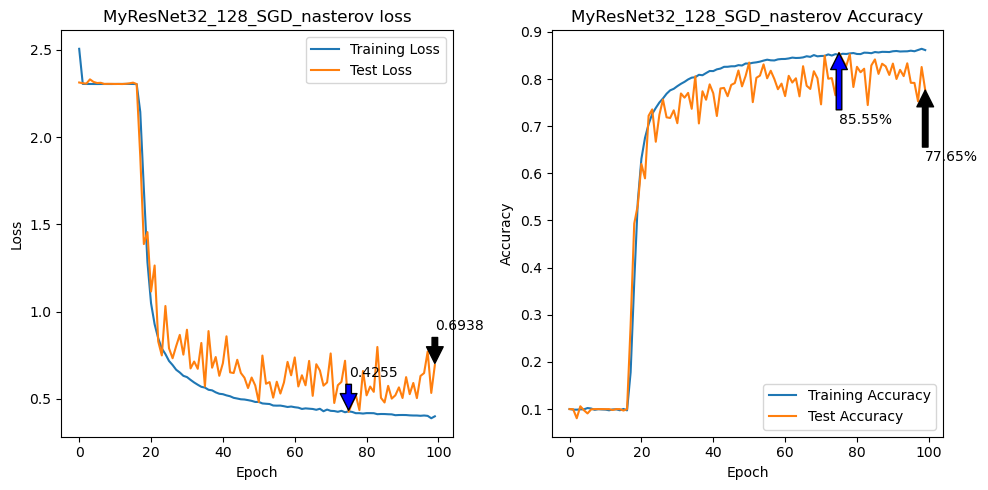

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=2.5058, train_acc=0.1001, test_loss=2.3128, test_acc=0.1000, lr=0.1000
2 epoch: train_loss=2.3045, train_acc=0.0989, test_loss=2.3084, test_acc=0.0998, lr=0.1000
3 epoch: train_loss=2.3043, train_acc=0.0988, test_loss=2.3066, test_acc=0.0806, lr=0.1000
4 epoch: train_loss=2.3043, train_acc=0.0995, test_loss=2.3308, test_acc=0.1060, lr=0.1000
5 epoch: train_loss=2.3042, train_acc=0.0995, test_loss=2.3160, test_acc=0.0976, lr=0.1000
6 epoch: train_loss=2.3040, train_acc=0.1022, test_loss=2.3099, test_acc=0.0908, lr=0.1000
7 epoch: train_loss=2.3042, train_acc=0.1013, test_loss=2.3110, test_acc=0.0994, lr=0.1000
8 epoch: train_loss=2.3042, train_acc=0.0984, test_loss=2.3044, test_acc=0.1000, lr=0.1000
9 epoch: train_loss=2.3041, train_acc=0.0998, test_loss=2.3051, test_acc=0.1000, lr=0.1000
10 epoch: train_loss=2.3041, train_acc=0.0993, test_loss=2.3050, test_acc=0.1000, lr=0.1000
11 epoch: train_loss=2.3044, train_acc=0.0989, test_loss=2.3042, test_acc=0.0999, lr=0.10